# Project Overview
Using machine learning techniques, we aim to fine tune and build a model that can identify companies as investment grade or non-investment grade based on available financial metrics. Rating agencies routinely assign credit ratings to public companies, and these ratings influence funding and investment decisions for many financial firms.

When scoring the models, we primarily use the macro average f1-score to balance recall and precision. We chose this metric as it provides a more holistic view of the model's predictive capability, and since we will resample the data to promote even class distributions, the macro average assigns equal weight to each target class.

# Data inspection

In the cell below, we import all the relevant libraries for inspecting, processing, and analyzing our data.

In [1]:
# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, accuracy_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

Now that the libraries have been imported, we gather the dataset, pass it through a dataframe, and preview the first few rows.

In [2]:
# import data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/corporateCreditRatingWithFinancialRatios.csv')

# preview the dataset
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


Our dataset has 25 columns, and the target variable will be `Binary Rating`. The `Binary Rating` column assigns a value of 1 to investment-grade corporations and 0 to junk-grade corporations.

In the following cell, we inspect the distribution of `Binary Rating`, our target variable. Ideally, there should be an even number of observations between investment-grade and junk-grade firms.

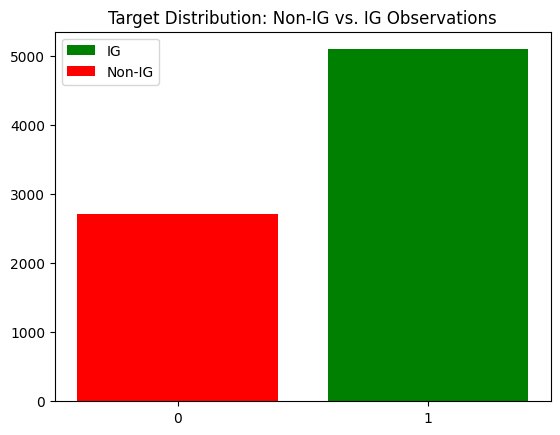

In [3]:
# use the value_counts() method on the target column to get the label and corresponding number of observations
classes=list(data['Binary Rating'].value_counts().index)
count=list(data['Binary Rating'].value_counts().values)

# plot the distribution
ax=plt.subplot()
ax.bar(classes[0], count[0], color='green', label='IG')
ax.bar(classes[1], count[1], color='red', label='Non-IG')
ax.set_title('Target Distribution: Non-IG vs. IG Observations')
plt.legend()
plt.xticks(classes)
plt.show()

From the graph above, it's evident that there are far more observations for investment-grade corporations than non-investment-grade. To address this class imbalance, we will use a sampling technique called `SMOTE`, which creates synthetic samples of the minority class. The implementation will be shown alongside our data cleaning and preprocessing procedures.

In the meantime, we continue to inspect all the columns of the original dataset by using the `info()` function to understand what data types we are handling.

In [4]:
# inspect the data type of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rating Agency                  7805 non-null   object 
 1   Corporation                    7805 non-null   object 
 2   Rating                         7805 non-null   object 
 3   Rating Date                    7805 non-null   object 
 4   CIK                            7805 non-null   int64  
 5   Binary Rating                  7805 non-null   int64  
 6   SIC Code                       7805 non-null   float64
 7   Sector                         7805 non-null   object 
 8   Ticker                         7805 non-null   object 
 9   Current Ratio                  7805 non-null   float64
 10  Long-term Debt / Capital       7805 non-null   float64
 11  Debt/Equity Ratio              7805 non-null   float64
 12  Gross Margin                   7805 non-null   f

Most of our features are numeric with data type `float64`. However, we have several `object` features for information such as company name, stock exchange ticker, and rating date. Logically speaking, these features shouldn't impact a firm's credit rating. Hence, we will drop such features in the following cell.

For reference, `CIK` is a Central Index Key used by the SEC to identify companies, while `SIC Code` represents the industry. `CIK` can just be thought of as another name. Additionally, we already have information about the firm's line of business through the `Sector` column. Hence, we include `CIK` and `SIC Code` in the list of dropped columns below.

In [5]:
# drop the columns
data = data.drop(columns=["Corporation", "Rating Date", "CIK", "SIC Code", "Ticker"])

Now that we've removed some columns, we can inspect the distribution of each numerical attribute within the dataset.

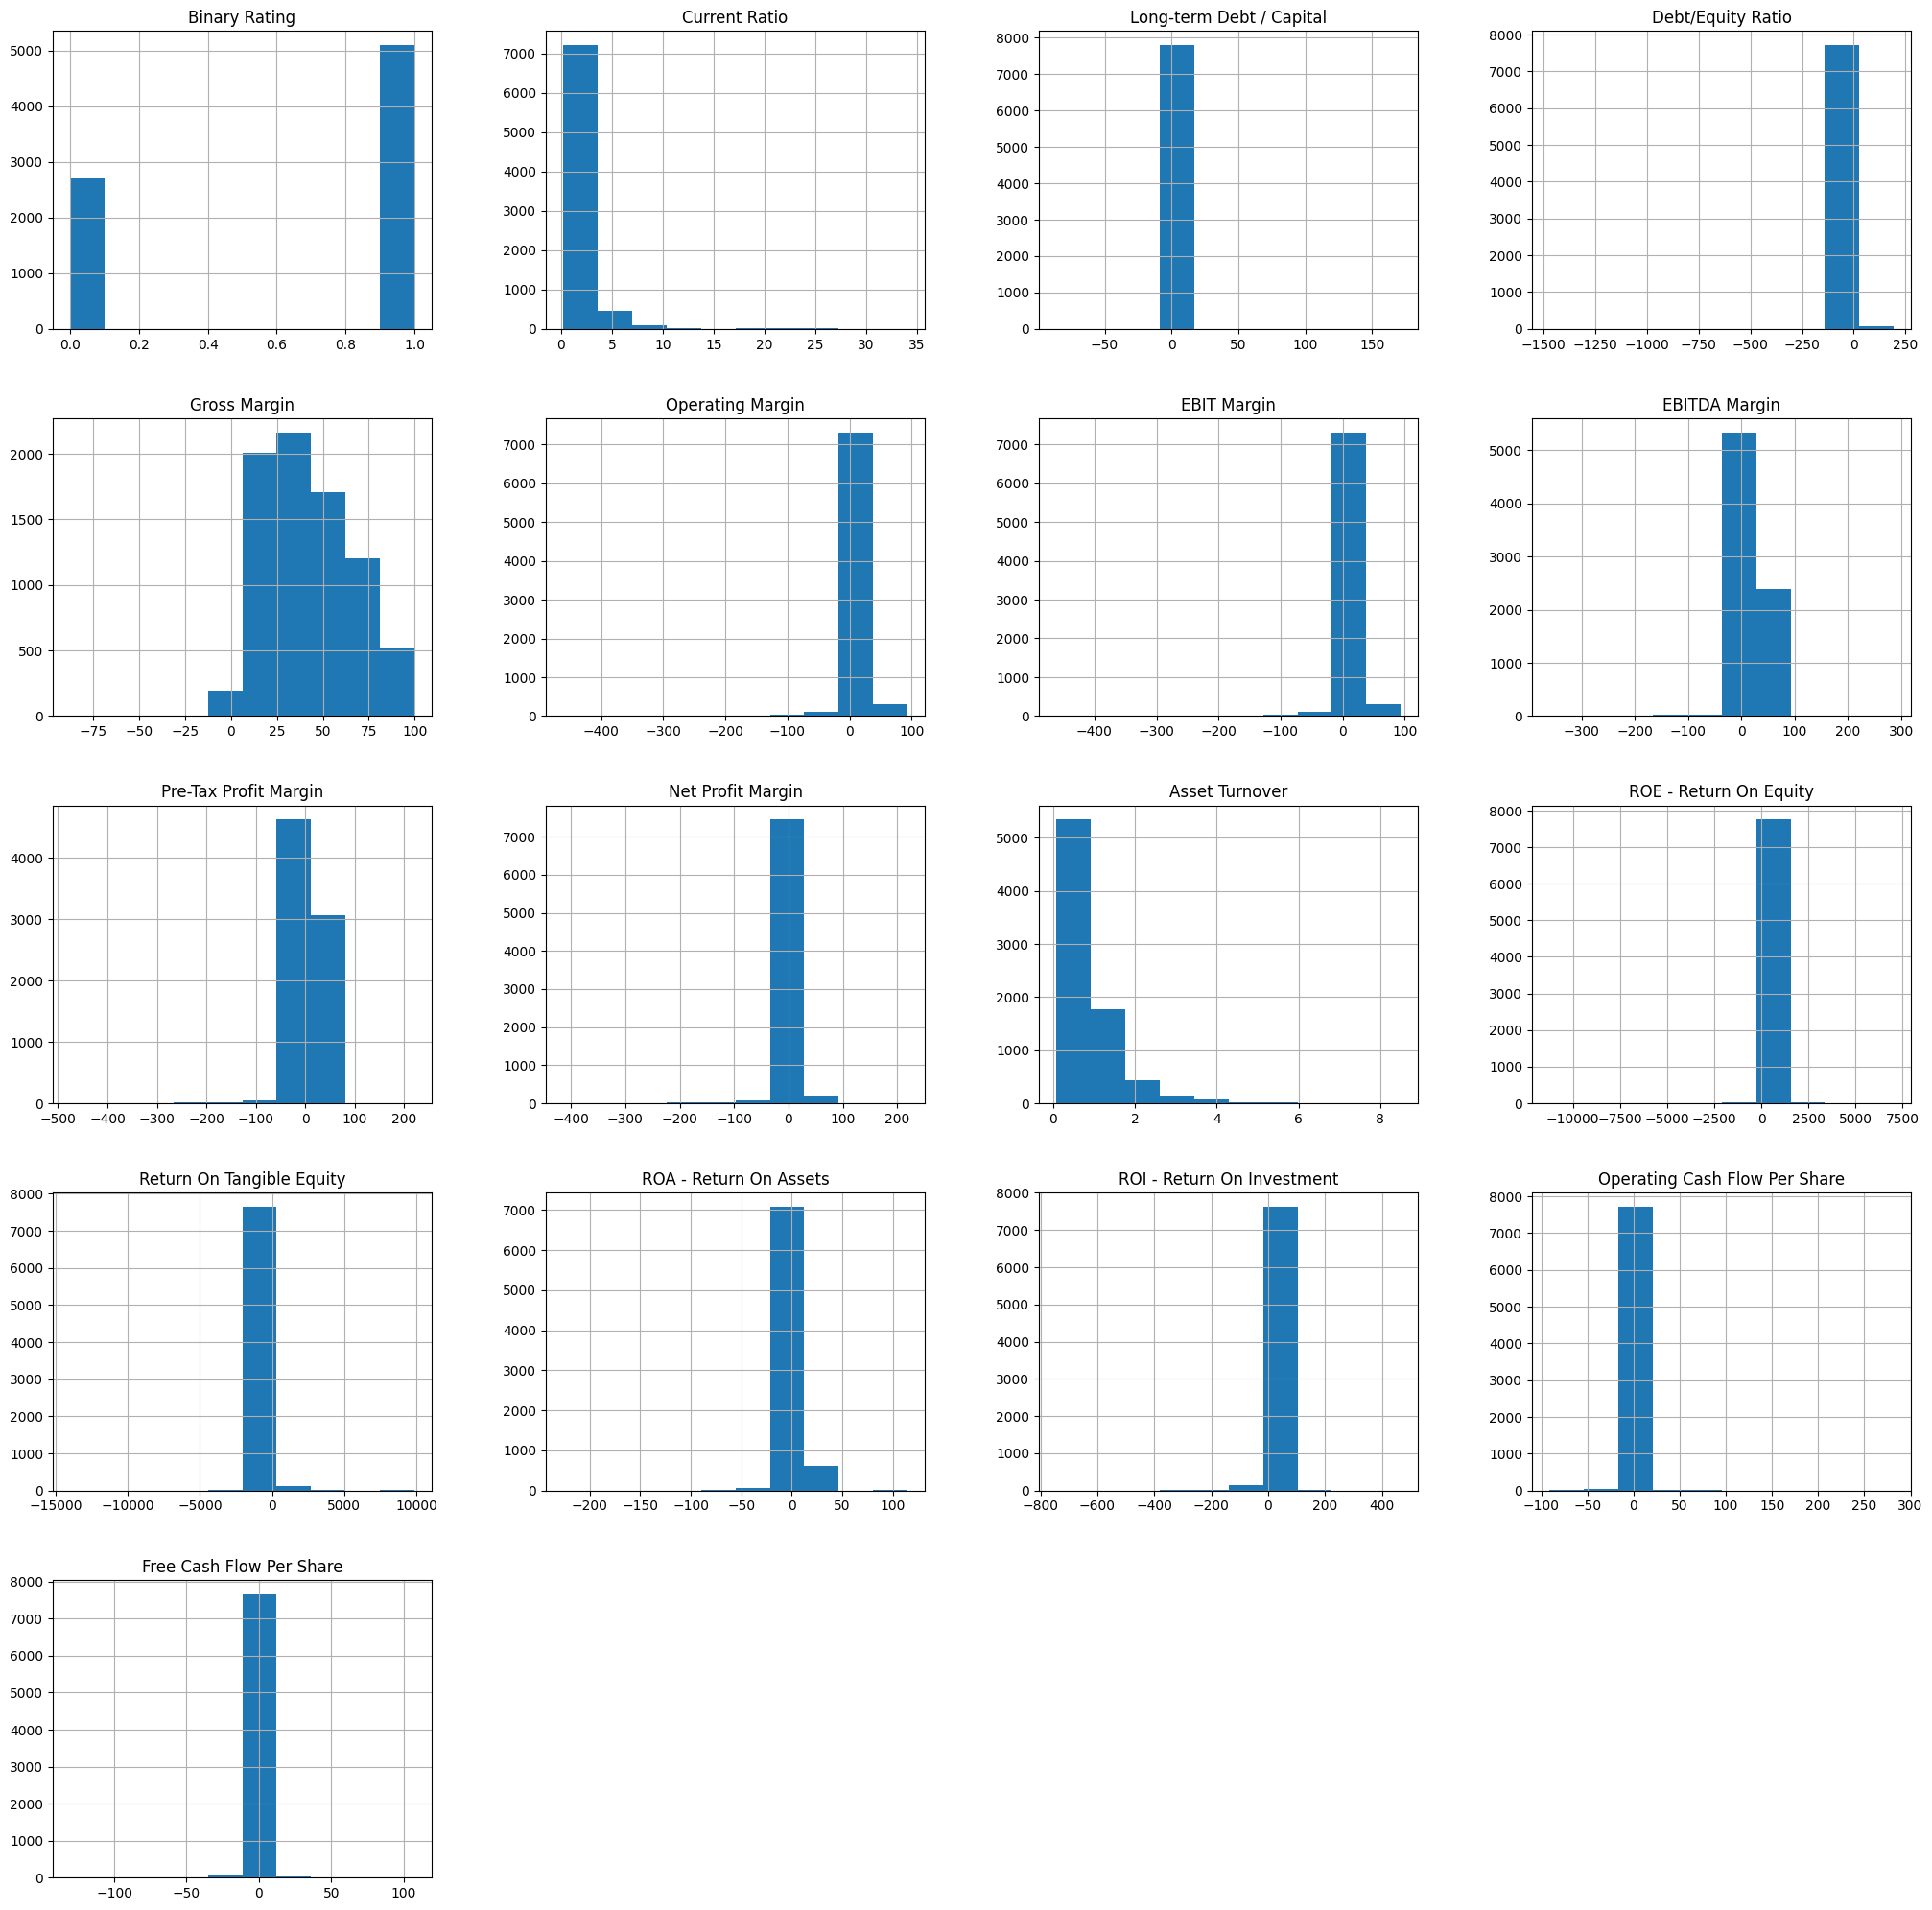

In [6]:
# inspect the distribution of numerical attributes in the dataset
ax = data.hist(figsize=(25,25))

At a glance, we can see that these features have very different scales. Before training the data, we will standardize the inputs so that observations have a balanced scale.

The final step of our data inspection process is to check for multicollinearity. Multicollinearity occurs when several variables in a model are related, undermining the statistical significance of independent variables. As part of our inspection, we construct a correlation matrix below.

In [7]:
corr_matrix = data.iloc[:, 4:].corr()
corr_matrix

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
Current Ratio,1.000000,-0.004422,0.007607,-0.119005,-0.039968,-0.040325,-0.095895,-0.036191,-0.018826,-0.049083,-0.022254,-0.008224,-0.002297,-0.025053,-0.021045,0.006524
Long-term Debt / Capital,-0.004422,1.000000,-0.004481,-0.000660,-0.010255,-0.010299,-0.007124,-0.015440,-0.017155,-0.010404,0.001803,-0.004122,-0.018936,0.551874,0.011356,0.012966
Debt/Equity Ratio,0.007607,-0.004481,1.000000,0.003872,0.001333,0.001393,-0.001535,0.007330,0.005694,-0.003112,0.462107,0.003809,0.008044,0.007103,0.007197,-0.003935
Gross Margin,-0.119005,-0.000660,0.003872,1.000000,0.180366,0.180612,0.364032,0.138797,0.109143,-0.505110,-0.000769,-0.028778,0.045433,0.018835,0.010243,-0.011238
Operating Margin,-0.039968,-0.010255,0.001333,0.180366,1.000000,0.999700,0.920759,0.916338,0.879209,-0.107301,-0.001834,0.012389,0.754847,0.423420,0.199485,-0.079138
EBIT Margin,-0.040325,-0.010299,0.001393,0.180612,0.999700,1.000000,0.921193,0.916165,0.879104,-0.108046,-0.001836,0.012313,0.754676,0.423368,0.202016,-0.079564
EBITDA Margin,-0.095895,-0.007124,-0.001535,0.364032,0.920759,0.921193,1.000000,0.819170,0.767419,-0.274075,-0.010407,0.005155,0.638675,0.362099,0.189693,-0.084401
Pre-Tax Profit Margin,-0.036191,-0.015440,0.007330,0.138797,0.916338,0.916165,0.819170,1.000000,0.965150,-0.049702,0.004329,0.026279,0.797267,0.447459,0.188690,-0.070633
Net Profit Margin,-0.018826,-0.017155,0.005694,0.109143,0.879209,0.879104,0.767419,0.965150,1.000000,-0.039706,0.011475,0.027545,0.787621,0.447371,0.180768,-0.076348
Asset Turnover,-0.049083,-0.010404,-0.003112,-0.505110,-0.107301,-0.108046,-0.274075,-0.049702,-0.039706,1.000000,0.024105,0.065913,0.113655,0.091659,0.017271,0.022692


Some cells in the correlation matrix have high values exceeding 0.9. For instance, EBIT Margin and Operating Margin have a correlation of 0.999700, and this makes sense because the value of EBIT is used to calculate operating margin. Evidently, our dataset has some multicollinearity. We will address this using the `variance inflation factor (VIF)`.

# Data preprocessing and cleaning
Now that we've understood our data and identified areas of concern, we can start to preprocess and clean.

We start by filling any empty rows, if they exist. We use the `SampleImputer` function and define `strategy='mean'` to fill any empty cells with the average of that column.

In [8]:
# instantiate an inputer to fill empty values, if they exist, with the average
imputer = SimpleImputer(strategy='mean')

# we apply the inputer on a copy of the dataset
data_imputed = data.copy()
numeric_columns = data_imputed.select_dtypes(include=['float64', 'int64']).columns
data_imputed[numeric_columns] = imputer.fit_transform(data_imputed[numeric_columns])

Next, we encode any remaining categorical (non-numerical) variables. We use the `LabelEncoder()` function to handle these features.

In [9]:
# encode categorical variables
categorical_columns = data_imputed.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col, le in label_encoders.items():
    data_imputed[col] = le.fit_transform(data_imputed[col])

With the encoded values, we can identify the X and y variables and proceed with scaling X. The first few rows of the scaled dataset are shown.

In [10]:
# identify X and y
X = data_imputed.drop(columns=['Binary Rating', 'Rating'])
y = data_imputed['Binary Rating'] # use 'Binary Rating' as target

# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# display the first few rows of the scaled inputs
pd.DataFrame(X_scaled, columns=X.columns).head()

,Rating Agency,Sector,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,1.012624,1.478474,-0.403644,0.000873,0.020530,1.482239,0.312253,0.310067,0.365559,0.177621,0.096734,-0.764973,-0.033733,-0.028709,-0.209897,-0.107590,0.250559,-0.034852
1,1.012624,-1.673453,-0.423316,-0.169496,-0.004936,0.051726,0.325949,0.323755,0.158597,0.438188,0.314851,-0.743282,0.026390,0.055768,-0.008809,0.607060,-0.037958,0.026707
2,1.012624,0.905397,0.000670,-0.061013,0.007202,-1.286119,-0.322542,-0.324358,-0.674261,-0.201199,-0.160213,2.315788,-0.010031,-0.010120,0.075563,0.105548,-1.336750,-1.026112
3,1.012624,1.478474,-0.567524,0.006845,0.022399,0.929875,0.271849,0.269686,0.322665,0.231604,0.125926,-0.797580,-0.027363,-0.025459,-0.207752,-0.080978,0.208925,-0.140544
4,1.012624,0.905397,-0.329536,-0.071664,0.006567,-1.625720,-0.400697,-0.402467,-0.758313,-0.266630,-0.222157,5.857507,-0.020925,-0.004459,-0.177620,0.045459,0.246725,0.316813


Now that we've scaled the predictors, we will address highly correlated variables using `VIF`.

In [11]:
# calculate the VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# display sorted VIF values to identify multicollinearity
vif_data.sort_values(by="VIF", ascending=False)

,Feature,VIF
7,EBIT Margin,1701.767458
6,Operating Margin,1693.731009
9,Pre-Tax Profit Margin,21.489715
10,Net Profit Margin,15.447313
8,EBITDA Margin,10.453065
14,ROA - Return On Assets,4.640824
15,ROI - Return On Investment,3.213814
3,Long-term Debt / Capital,2.021241
5,Gross Margin,1.626653
11,Asset Turnover,1.596840


A `VIF` is a ratio that quantifies how much the variance is inflated. Specifically, it captures how much the regression coefficient increases as a result of correlations between variables. Based on this definition, we aim to eliminate predictors with a `VIF` exceeding 5.

We identify `EBIT Margin`, `Operating Margin`, `Pre-Tax Profit Margin`, `Net Profit Margin`, and `EBITDA Margin` as high `VIF` variables that need to be excluded. This makes sense, as many of the other metrics in this list are calculated with the aforementioned variables. In the next cell, we drop the high `VIF` predictors.

In [12]:
# identify the features with high VIF and remove them from the set of predictors
collinear_features = ["EBIT Margin", "Operating Margin", "Pre-Tax Profit Margin", "Net Profit Margin", "EBITDA Margin"]
X_reduced = X.drop(columns=collinear_features)

X_reduced_scaled = scaler.fit_transform(X_reduced)
vif_reduced = pd.DataFrame()
vif_reduced["Feature"] = X_reduced.columns
vif_reduced["VIF"] = [variance_inflation_factor(X_reduced_scaled, i) for i in range(X_reduced_scaled.shape[1])]

# display reduced VIF values in order
vif_reduced.sort_values(by="VIF", ascending=False)

,Feature,VIF
10,ROI - Return On Investment,3.171965
9,ROA - Return On Assets,2.259362
3,Long-term Debt / Capital,2.007793
6,Asset Turnover,1.409760
5,Gross Margin,1.403906
7,ROE - Return On Equity,1.279160
4,Debt/Equity Ratio,1.274125
2,Current Ratio,1.044214
11,Operating Cash Flow Per Share,1.033773
12,Free Cash Flow Per Share,1.018171


The final step of this stage is to resample the data to account for class imbalances. As previously mentioned, we will use the `SMOTE` technique to create synthetic samples of the minority class, which is the junk-rated corporations (`Binary Rating = 0`).

To do this, we split the data into training and testing sets. Then, we create a balanced training set with `SMOTE` and check that there's a balanced number of observations for each class. By calling the `value_counts()` function, we can see that we've made the distribution uniform across the target classes.

In [13]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced_scaled, y, test_size=0.2, random_state=42)

In [14]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [15]:
# check that the target classes are balanced
y_train_balanced.value_counts()

,count
Binary Rating,
1.0,4060
0.0,4060


We've concluded our preprocessing and cleaning procedures. In the sections that follow, we use sklearn libraries to evaluate different machine learning models and implement our own customizations to the models for improved performance.

# Baseline models with libraries

## a) kNN

              precision    recall  f1-score   support

      Non-IG       0.79      0.89      0.84       522
          IG       0.94      0.88      0.91      1039

    accuracy                           0.88      1561
   macro avg       0.86      0.88      0.87      1561
weighted avg       0.89      0.88      0.88      1561



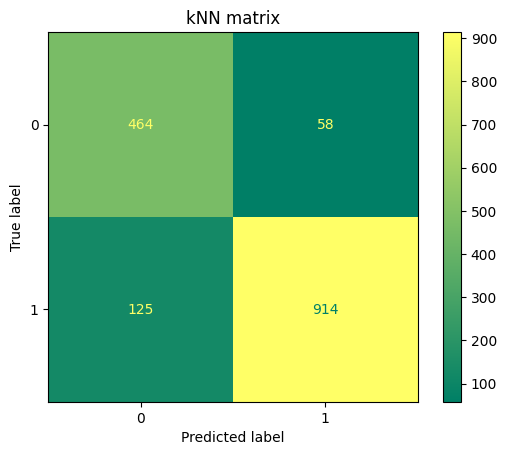

In [16]:
# initialize knn
knn = KNeighborsClassifier(n_neighbors=5)

# train the model and make predictions
knn.fit(X_train_balanced, y_train_balanced)
knn_predictions = knn.predict(X_test)

# generate a report
knn_report = classification_report(y_test, knn_predictions, target_names = ['Non-IG', 'IG'])

# display the report's results
print(knn_report)

# display confusion matrix
cm = confusion_matrix(y_test, knn_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='summer')
plt.title("kNN matrix")
plt.show()

From the classification report and confusion matrix, it's evident that the baseline kNN model performs quite well across all classification metrics. Later, we will aim to improve the model slightly with custom functions to identify the best number of neighbors based on error rate.

## b) Logistic Regression

              precision    recall  f1-score   support

      Non-IG       0.56      0.73      0.64       522
          IG       0.84      0.71      0.77      1039

    accuracy                           0.72      1561
   macro avg       0.70      0.72      0.70      1561
weighted avg       0.75      0.72      0.73      1561



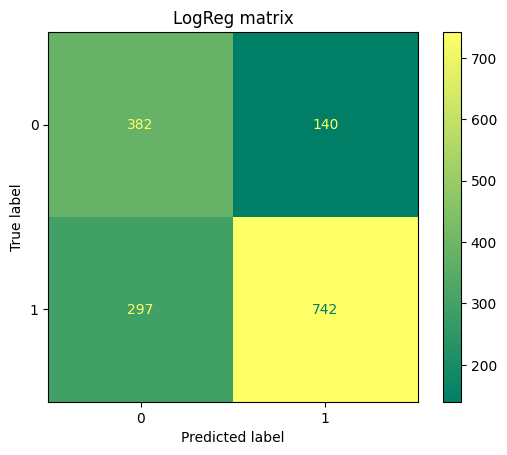

In [17]:
# initialize logistic regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# train the model and make predictions
log_reg.fit(X_train_balanced, y_train_balanced)
log_reg_predictions = log_reg.predict(X_test)

# generate a report
log_reg_report = classification_report(y_test, log_reg_predictions, target_names = ['Non-IG', 'IG'])

# display the report's results
print(log_reg_report)

# display confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='summer')
plt.title("LogReg matrix")
plt.show()

Compared to kNN, the baseline logistic regression model doesn't perform nearly as well. Specifically, the area of concern is the precision within the `Non-IG` class. In the context of credit ratings, we will assume that the cost of a false positive (saying a corporation is IG when it is not) is higher. Hence, we aim to prioritize improving precision while maintaining overall f1-score, which measures predictive performance. We will address this issue with a custom function to identify feature importances and rerun the logistic regression on a subset of selected predictors.

## c) Naive Bayes

              precision    recall  f1-score   support

      Non-IG       0.75      0.25      0.37       522
          IG       0.72      0.96      0.82      1039

    accuracy                           0.72      1561
   macro avg       0.73      0.60      0.60      1561
weighted avg       0.73      0.72      0.67      1561



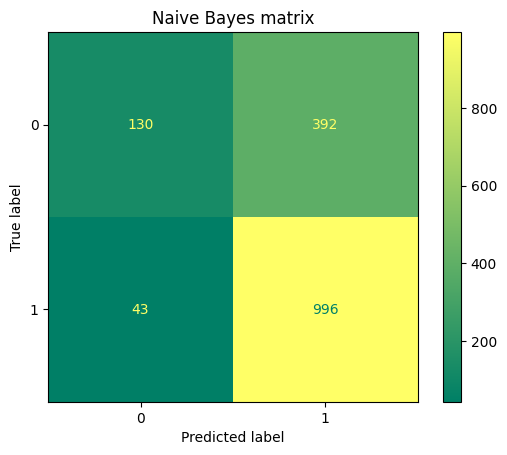

In [18]:
# initialize Naive Bayes
gnb = GaussianNB()

# train the model and make predictions
gnb.fit(X_train_balanced, y_train_balanced)
NB_predictions = gnb.predict(X_test)

# generate a report
NB_report = classification_report(y_test, NB_predictions, target_names = ['Non-IG', 'IG'])

# display the report's results
print(NB_report)

# display confusion matrix
cm = confusion_matrix(y_test, NB_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='summer')
plt.title("Naive Bayes matrix")
plt.show()

The final classification method we use is Naive Bayes. Among the three baseline models, Naive Bayes appears to have the lowest f1-score, while precision and accuracy metrics are moderate. Similar to our approach with kNN and logistic regression, we aim to tune the Naive Bayes model from the sklearn library with our own techniques.

# Tuned models and custom functions

## a) Tuned kNN with optimal K

In the standard kNN model from sklearn, we followed the default value for `n_neighbors = 5`. By creating our own function to find the best value for this parameter, we improve the baseline model's performance. In the next few cells, we iterate through different values of K and calculate the corresponding f1-score to decide what value we should set `n_neighbors` to. Our results are shown below.

In [19]:
# define a function that finds the best K
def optimal_k(X_train, y_train, max_k=30, test_size=0.2, random_state=42):
  X_train_k, X_val, y_train_k, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
  f1_scores = {}

  # iterate through different values of K
  for k in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_k, y_train_k)

    y_val_pred = knn.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='macro')
    f1_scores[k] = f1

    # the best K has the highest score
    best_k = max(f1_scores, key=f1_scores.get)

  return best_k, f1_scores

In [20]:
best_k, f1_scores = optimal_k(X_train_balanced, y_train_balanced)

print("K with best score:", best_k)

K with best score: 1


              precision    recall  f1-score   support

      Non-IG       0.89      0.90      0.90       522
          IG       0.95      0.95      0.95      1039

    accuracy                           0.93      1561
   macro avg       0.92      0.92      0.92      1561
weighted avg       0.93      0.93      0.93      1561



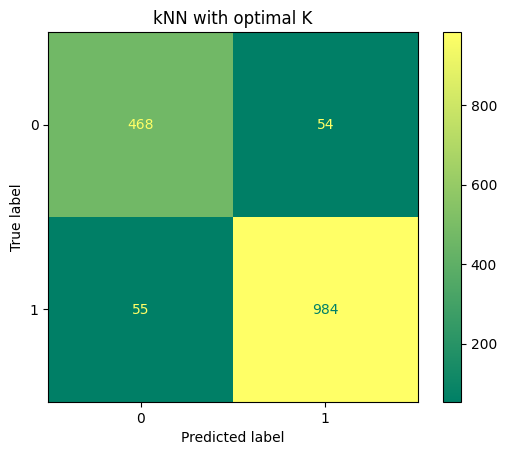

In [21]:
# initialize a kNN model based on the best K found
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_balanced, y_train_balanced)
knn_predictions_optimalk = knn.predict(X_test)

# generate and print the report
knn_report = classification_report(y_test, knn_predictions_optimalk, target_names = ['Non-IG', 'IG'])
print(knn_report)

# plot confusion matrix
cm = confusion_matrix(y_test, knn_predictions_optimalk)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='summer')
plt.title("kNN with optimal K")
plt.show()

With our customizations, we were able to tune the kNN model and set `n_neighbors = 1`. The performance improved markedly, as shown in the classification report and confusion matrix. Overall accuracy increased from 88% to 93%, and the macro average f1 improved from 87% to 92%.

We want to note that a small value of `n_neighbors` can lead to high variance. We've already accounted for this in our resampling and input scaling techniques. Since there is a tradeoff between bias and variance, we are cognizant of the chosen value of `n_neighbors` and can adjust with our function as more data inputs are used.

# b) Tuned Logistic Regression with feature importances

To improve our baseline logistic regression function, we turn to feature importances and selection. In the cell below, we created a function to determine how influential each variable is. We extract the coefficient for each feature and plot the top ten features in the graph below.

In [22]:
def logreg_feature_importances(X_train, y_train, feature_names):

    # initialize the model and fit on the training data
    logreg = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
    logreg.fit(X_train, y_train)

    # get coefficients
    coefficients = logreg.coef_[0]

    # initialize a dataframe of feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Absolute Coefficient': np.abs(coefficients)
    })

    # sort feature importance by absolute value of coefficients
    importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

    return importance_df

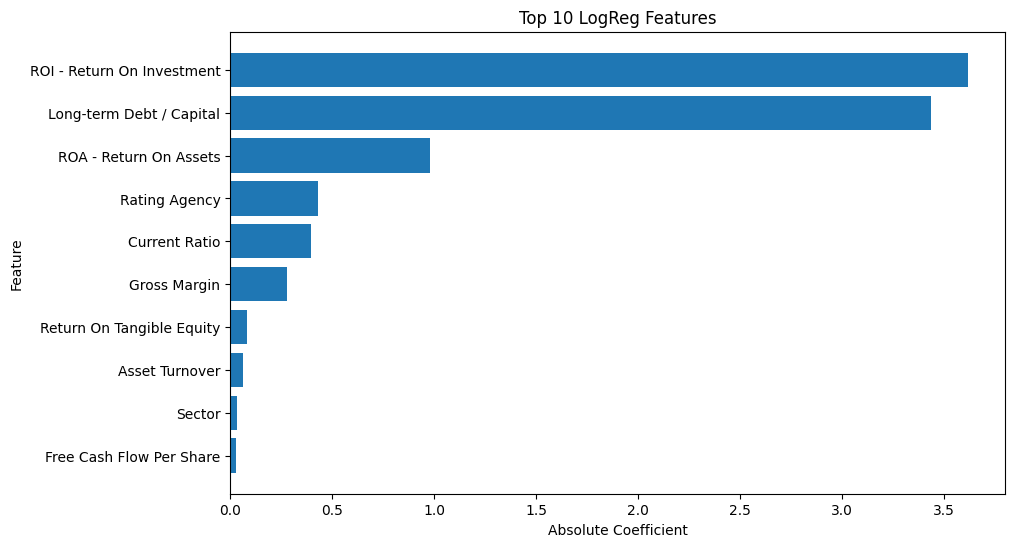

In [23]:
feature_names = X_reduced.columns
importance_df = logreg_feature_importances(X_train_balanced, y_train_balanced, feature_names)

# plot the features and their importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Absolute Coefficient'][:10][::-1])
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.title("Top 10 LogReg Features")
plt.show()

With this information, we run logistic regression again with only ten attributes. Additionally, we do not resample the target class this time, since `SMOTE` assumes that all predictors are equally important. The results are displayed below.

              precision    recall  f1-score   support

      Non-IG       0.76      0.48      0.59       522
          IG       0.78      0.93      0.85      1039

    accuracy                           0.78      1561
   macro avg       0.77      0.70      0.72      1561
weighted avg       0.77      0.78      0.76      1561



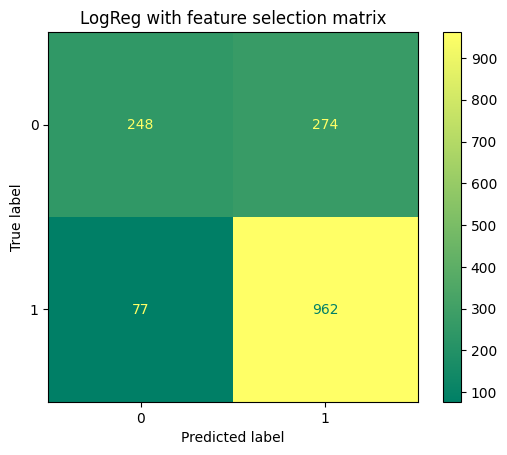

In [24]:
# get selected features from the importance_df based on the optimal number of predictors
selected_features = importance_df['Feature'][:10].tolist()

# get X for the selected features
X_selected_features = X_reduced[selected_features]
X_selected_features_scaled = scaler.fit_transform(X_selected_features)

# split the data based on the selected features
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_features_scaled, y, test_size=0.2, random_state=42)

# initialize a logreg model
log_reg_selected = LogisticRegression(max_iter=1000, random_state=42)

# refit the data on the selected training set
log_reg_selected.fit(X_train_selected, y_train_selected)

# get predictions
log_reg_selected_predictions = log_reg_selected.predict(X_test_selected)

# generate and print the report
log_reg_selected_report = classification_report(y_test_selected, log_reg_selected_predictions, target_names = ['Non-IG', 'IG'])
print(log_reg_selected_report)

# display confusion matrix
cm = confusion_matrix(y_test, log_reg_selected_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='summer')
plt.title("LogReg with feature selection matrix")
plt.show()

Through this, we've managed to enhance our precision in the logistic regression model. Though our recall score dropped slightly for the `Non-IG` class, we've increased the macro and weighted average f1-scores, which balances recall and precision. This means that precision improved without the expense of too much recall.

# c) Tuned Naive Bayes with principal component analysis (PCA)
Lastly, we attempt to improve the baseline Naive Bayes model with PCA. Since our model has over ten predictors, we might benefit from dimensionality reduction. The following cell builds a function to iteratively perform PCA on the training set to identify the number of components that results in the highest score. The function takes in the training and testing data, the maximum number of components considered, and the classification metric of choice.

In [25]:
# define a function that searches for the number of components with the maximum score
def PCA_max_score(X_train, X_test, y_train, y_test, max_components, metric):

    # initialize variables
    results = []
    best_score = -float('inf')
    best_num_components = 0

    # iterate through different numbers of components
    for n_components in range(1, max_components + 1):

        # perform PCA for each iteration
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # classify with Naive Bayes
        gnb = GaussianNB()
        gnb.fit(X_train_pca, y_train)
        y_pred = gnb.predict(X_test_pca)

        # calculate the score based on the chosen metric
        if metric == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metric == 'f1':
            score = f1_score(y_test, y_pred, average='macro')
        elif metric == 'recall':
            score = recall_score(y_test, y_pred, average='macro')
        elif metric == 'precision':
            score = precision_score(y_test, y_pred, average='macro')

        # update the best score with each iteration
        if score > best_score:
          best_score = score
          best_num_components = n_components

        results.append({'num_components': n_components, 'score': score})

    # print the results
    print(f"Maximum {metric} score: {np.round(best_score, 4)}")
    print(f"Number of PCA components: {best_num_components}")

    # get the results dataframe and the best number of components
    results_df = pd.DataFrame(results)
    optimal_num_pca = results_df.loc[results_df['score'].idxmax(), 'num_components']

    # plot number of components against score
    plt.figure(figsize=(8, 4))
    plt.plot(results_df['num_components'], results_df['score'], marker='o', color='orange')
    plt.xlabel('number of PCA components')
    plt.ylabel(f'{metric} score')
    plt.title(f'{metric} vs. number of PCA components')
    plt.show()

    return results_df, optimal_num_pca

The function is used to find the number of components that will maximize f1-score. To reiterate, the f1-score is chosen as the classification metric for this section as we aim to balance precision and recall (since the baseline Naive Bayes returned a recall score of 25% for the `Non-IG` class) even if the improvement is only slight. The results are printed and illustrated in the next cell.

Maximum f1 score: 0.6288
Number of PCA components: 9


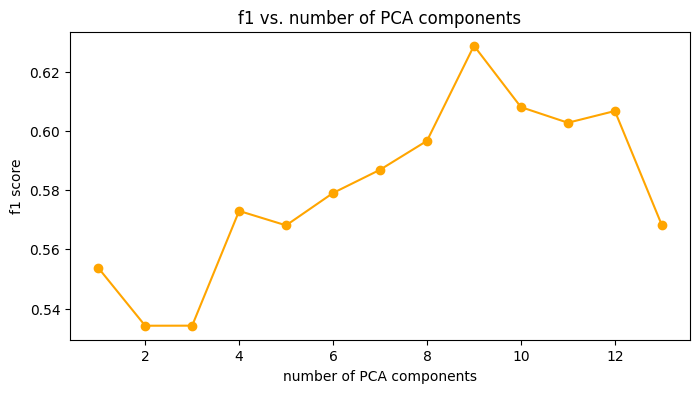

In [26]:
# plot how score changes with components and get optimal number of components
max_components = X_train_balanced.shape[1]
results_df, optimal_num_pca = PCA_max_score(X_train_balanced, X_test, y_train_balanced, y_test, max_components, 'f1')

The function determines that the number of components maximizing f1 is nine. We use this value to conduct PCA with `n_components = 9` and classify with Naive Bayes once again.

              precision    recall  f1-score   support

      Non-IG       0.63      0.35      0.45       522
          IG       0.73      0.90      0.81      1039

    accuracy                           0.71      1561
   macro avg       0.68      0.62      0.63      1561
weighted avg       0.70      0.71      0.69      1561



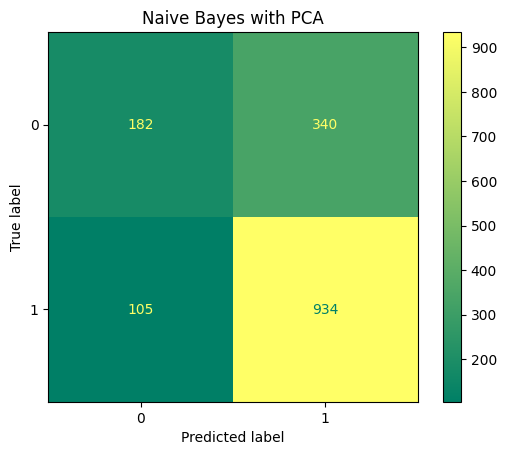

In [27]:
# define PCA with the number of components we found
pca = PCA(n_components = optimal_num_pca)

# fit and transform with PCA on the inputs
X_balanced_train_pca = pca.fit_transform(X_train_balanced)
X_test_pca = pca.transform(X_test)

# initialize the Naive Bayes model and fit on PCA transformed data
gnb = GaussianNB()
gnb.fit(X_balanced_train_pca, y_train_balanced)
gnb_pca_predictions = gnb.predict(X_test_pca)

# generate and print the report
gnb_pca_report = classification_report(y_test, gnb_pca_predictions, target_names = ['Non-IG', 'IG'])
print(gnb_pca_report)

# display confusion matrix
cm = confusion_matrix(y_test, gnb_pca_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='summer')
plt.title("Naive Bayes with PCA")
plt.show()

Overall, we've managed to improve our model's macro average f1-score from 60% to 63%, and this mainly comes from an increased recall score. Though we managed to make some enhancements, the Naive Bayes model has mediocre performance compared to the tuned kNN and Logistic Regression models.

# Conclusion

By starting with baseline models and attempting to improve them by hypertuning with customized functions, we conclude that the best algorithm for this task is the kNN classifier with `n_neighbors = 1`. To recap, below is our tuning function and final model.

              precision    recall  f1-score   support

      Non-IG       0.89      0.90      0.90       522
          IG       0.95      0.95      0.95      1039

    accuracy                           0.93      1561
   macro avg       0.92      0.92      0.92      1561
weighted avg       0.93      0.93      0.93      1561



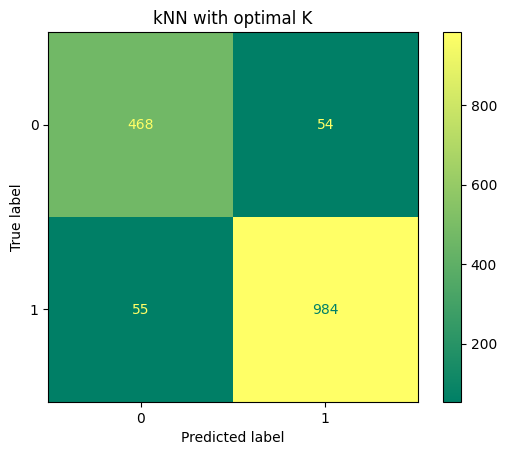

In [28]:
def optimal_k(X_train, y_train, max_k=30, test_size=0.2, random_state=42):
  X_train_k, X_val, y_train_k, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
  f1_scores = {}
  for k in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_k, y_train_k)
    y_val_pred = knn.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='macro')
    f1_scores[k] = f1
    best_k = max(f1_scores, key=f1_scores.get)
  return best_k, f1_scores


best_k, f1_scores = optimal_k(X_train_balanced, y_train_balanced)


knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_balanced, y_train_balanced)
knn_predictions_optimalk = knn.predict(X_test)


knn_report = classification_report(y_test, knn_predictions_optimalk, target_names = ['Non-IG', 'IG'])
print(knn_report)

cm = confusion_matrix(y_test, knn_predictions_optimalk)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='summer')
plt.title("kNN with optimal K")
plt.show()

Our confusion matrix plot demonstrates that most predictions are true positives (IG corporations) or true negatives (Non-IG corporations). The true positives and true negatives correspond to the lower right box and upper left box, respectively.

Though our other tuned models, logistic regression and naive bayes, didn't perform as well, we were able to draw some insights from them regarding relevant predictors.

From our modified logistic regression model, we deduced that the order of the top ten predictors are:
*   `ROI - Return on Investment`
*   `Long-term Debt / Capital`
*   `ROA - Return on Assets`
*   `Rating Agency`
*   `Current Ratio`
*   `Gross Margin`
*   `Return on Tangible Equity`
*   `Asset Turnover`
*   `Sector`
*   `Free Cash Flow Per Share`

Similarly, from our modified naive bayes model, we deduced that PCA with `n_components = 9` corresponds to the maximum f1-score.

Since feature importance is not explicitly defined within kNN, we can use the conclusions drawn from the other two models to refit our optimal kNN on a subset of the predictors. Using the feature importances from the logistic regression and the optimal number of components from PCA in naive bayes, we run our kNN one more time.

              precision    recall  f1-score   support

      Non-IG       0.91      0.89      0.90       522
          IG       0.95      0.95      0.95      1039

    accuracy                           0.93      1561
   macro avg       0.93      0.92      0.92      1561
weighted avg       0.93      0.93      0.93      1561



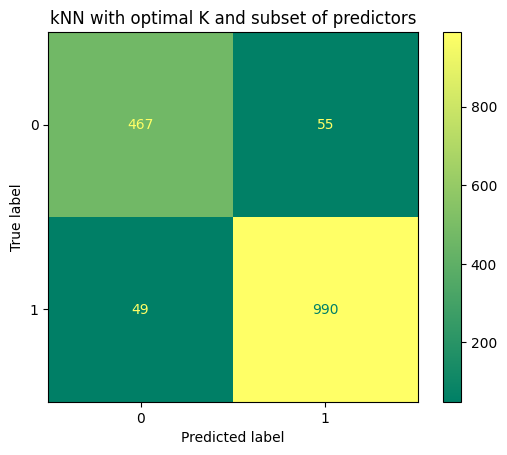

In [29]:
# select top nine features and scale
selected_features = importance_df['Feature'][:9].tolist()
X_selected_features = X_reduced[selected_features]
X_selected_features_scaled = scaler.fit_transform(X_selected_features)

# split the data and resample
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_features_scaled, y, test_size=0.2, random_state=42)
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train_selected)

# get the best k for kNN
best_k, f1_scores = optimal_k(X_train_balanced, y_train_balanced)

# initialize kNN model with the best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_balanced, y_train_balanced)
knn_predictions_optimalk = knn.predict(X_test_selected)

# print the report
knn_report = classification_report(y_test_selected, knn_predictions_optimalk, target_names = ['Non-IG', 'IG'])
print(knn_report)

# display the confusion matrix
cm = confusion_matrix(y_test_selected, knn_predictions_optimalk)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='summer')
plt.title("kNN with optimal K and subset of predictors")
plt.show()

Using the top few relevant features that were found through tuning logistic regression and naive bayes, we enhance the kNN model's precision and macro average f1-score once more. We consider this version the optimal model for the corporate credit rating classification taks.

# Potential next steps
*   Multiclass classification to assign a granular letter rating to corporations
*   Further analyses into the bias-variance tradeoff, as the the value of K = 1 in kNN suggests there may be significant variance
*   Analyze the observations in the lowest IG rating (Baa3 / BBB-) and the highest Non-IG rating (Ba1 / BB+) to determine which predictors are most indicative when corporations are near the threshold